In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

import joblib

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import os

Loading dataset

In [2]:
df = pd.read_csv(
    "/kaggle/input/refined-india-rainfall-and-crop-production-dataset/yeild_data.csv"
)

df.head()

,State_Name,Crop_Year,Season,Crop,Area,Production,Yeild,Rainfall
0,andaman and nicobar islands,2000,kharif,Arecanut,1254.0,2000.0,1.594896,1244.2
1,andaman and nicobar islands,2000,kharif,Rice,102.0,321.0,3.147059,1244.2
2,andaman and nicobar islands,2000,whole year,Banana,176.0,641.0,3.642045,2763.2
3,andaman and nicobar islands,2000,whole year,Cashewnut,720.0,165.0,0.229167,2763.2
4,andaman and nicobar islands,2000,whole year,Coconut,18168.0,65100000.0,3583.223250,2763.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231609 entries, 0 to 231608
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   State_Name  231609 non-null  object 
 1   Crop_Year   231609 non-null  int64  
 2   Season      231609 non-null  object 
 3   Crop        231609 non-null  object 
 4   Area        231609 non-null  float64
 5   Production  231609 non-null  float64
 6   Yeild       231609 non-null  float64
 7   Rainfall    231609 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 14.1+ MB


In [4]:
df.describe()

,Crop_Year,Area,Production,Yeild,Rainfall
count,231609.000000,2.316090e+05,2.316090e+05,231609.000000,231609.000000
mean,2005.660402,1.217855e+04,6.073611e+05,40.668370,719.952237
std,4.962559,3.856970e+04,1.745646e+07,814.676381,688.613306
min,1997.000000,1.000000e-01,0.000000e+00,0.000000,0.000000
25%,2002.000000,8.800000e+01,9.400000e+01,0.531915,102.100000
50%,2006.000000,6.200000e+02,7.960000e+02,1.000000,537.150000
75%,2010.000000,4.757810e+03,7.632000e+03,2.467294,1148.300000
max,2015.000000,1.020181e+06,1.250800e+09,88000.000000,3825.200000


In [5]:
df.shape

(231609, 8)

Boxplot before any cleaning

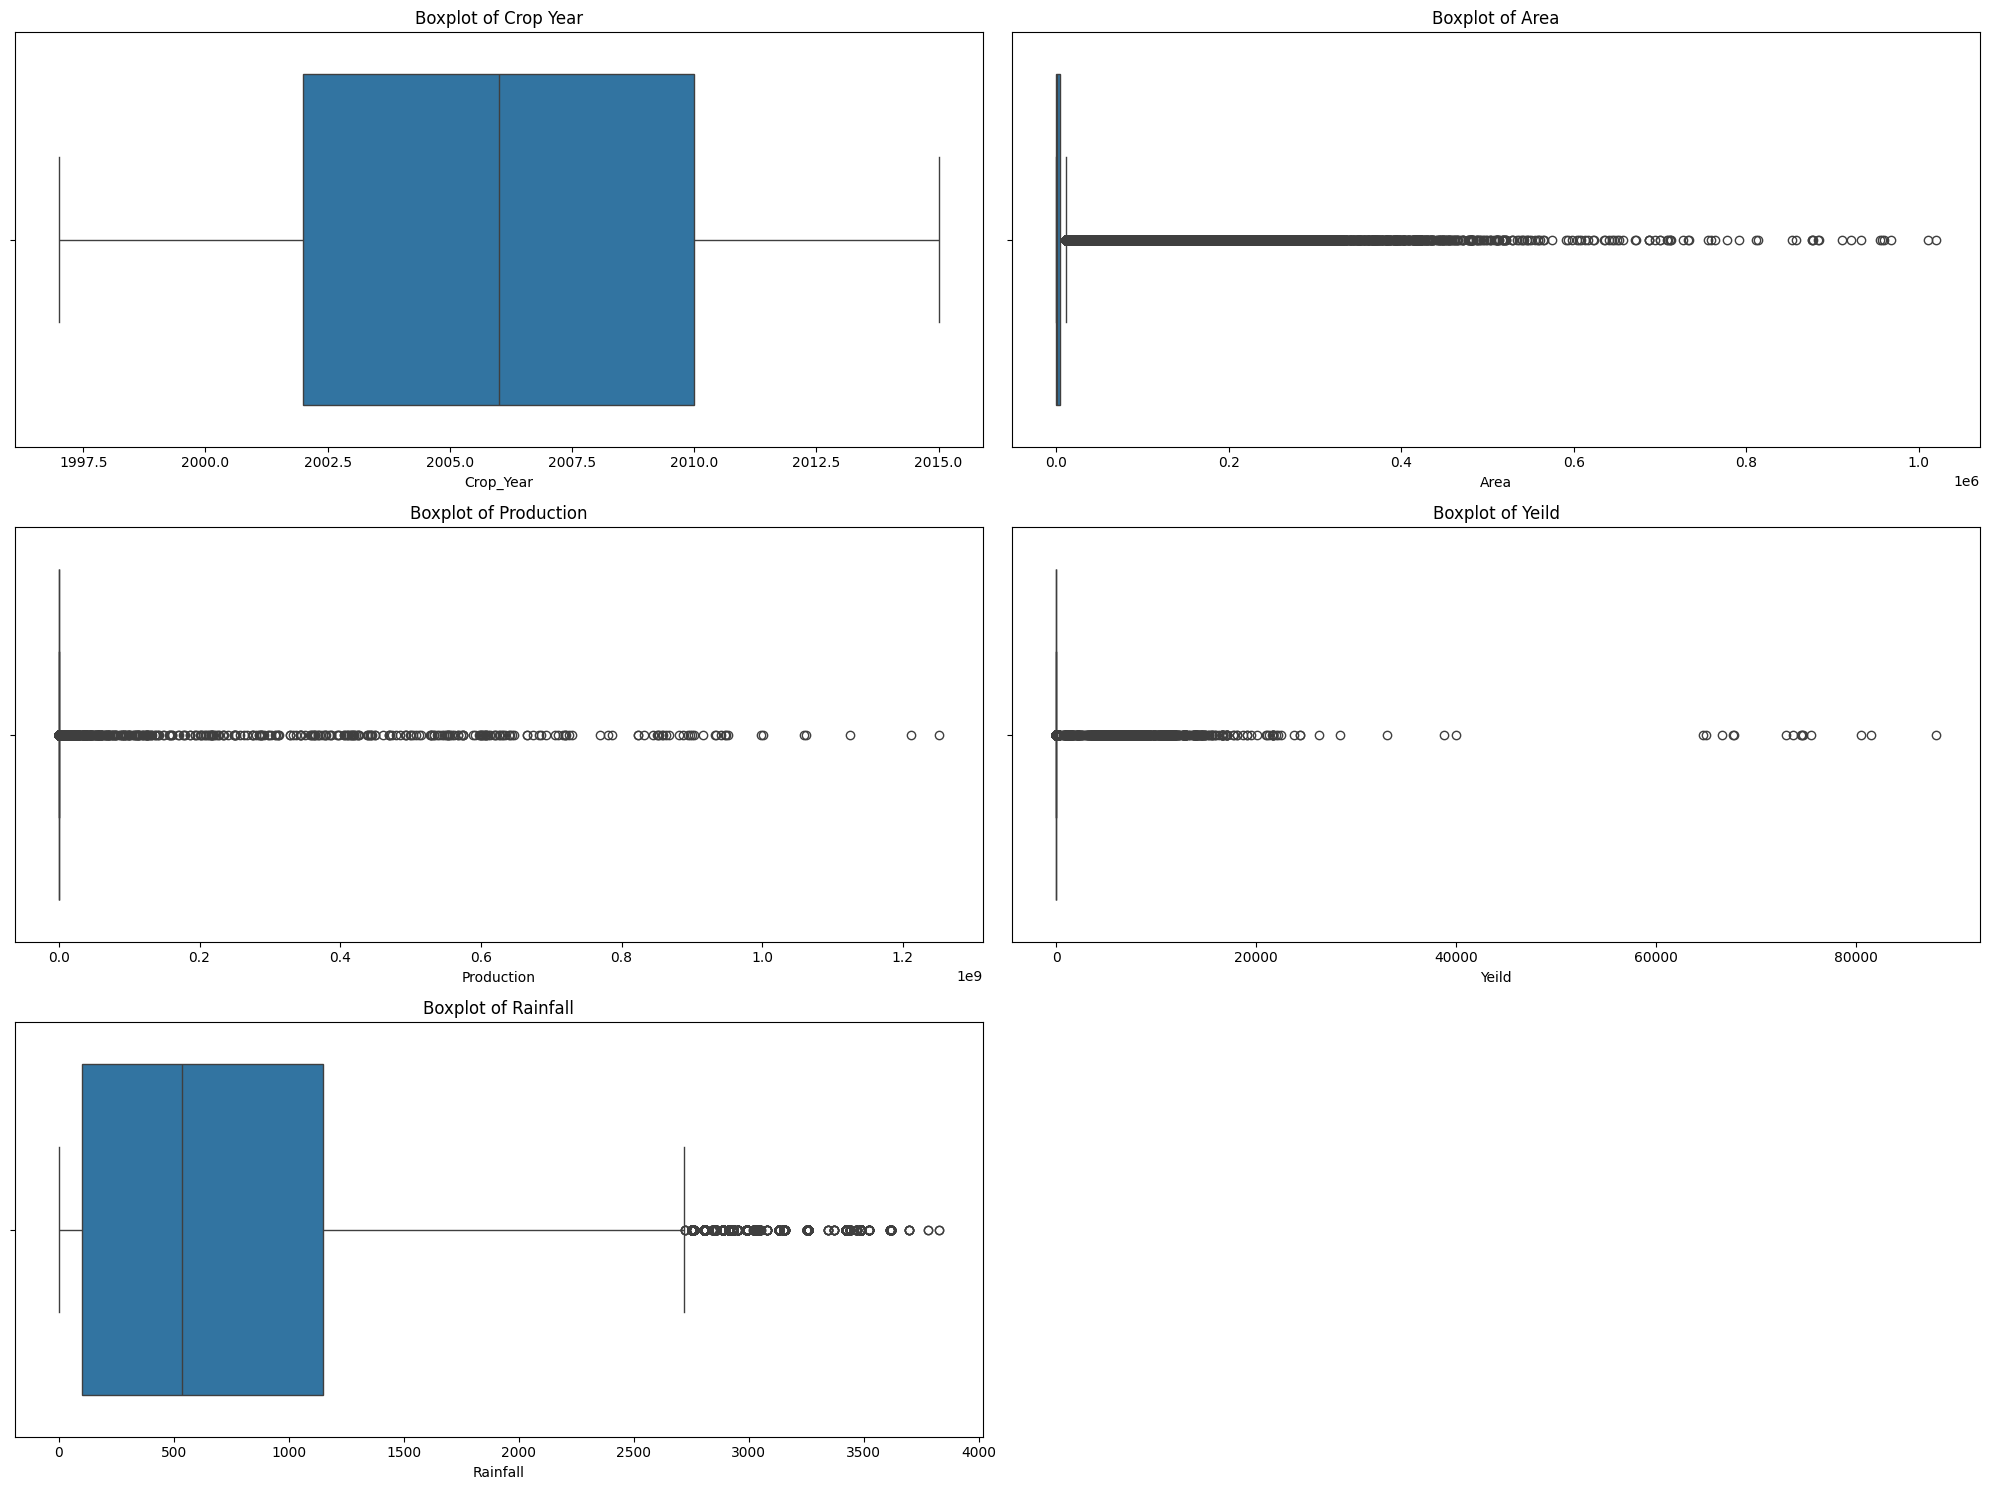

In [6]:

fig, axs = plt.subplots(3, 2, figsize=(20, 15)) 


sns.boxplot(x=df['Crop_Year'], ax=axs[0, 0])
axs[0, 0].set_title('Boxplot of Crop Year')

sns.boxplot(x=df['Area'], ax=axs[0, 1])
axs[0, 1].set_title('Boxplot of Area')



sns.boxplot(x=df['Production'], ax=axs[1, 0])
axs[1, 0].set_title('Boxplot of Production')


sns.boxplot(x=df['Yeild'], ax=axs[1, 1])
axs[1, 1].set_title('Boxplot of Yeild')



sns.boxplot(x=df['Rainfall'], ax=axs[2, 0])
axs[2, 0].set_title('Boxplot of Rainfall')


fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

As we can see that there are many 0 values for production which is an issue as production 0 would makes not sense.

In [7]:
df[df['Production']==0.0]

,State_Name,Crop_Year,Season,Crop,Area,Production,Yeild,Rainfall
375,andhra pradesh,2002,kharif,Soyabean,51.0,0.0,0.0,358.30
402,andhra pradesh,2002,whole year,Cucumber,18.0,0.0,0.0,659.20
454,andhra pradesh,2003,whole year,Cucumber,51.0,0.0,0.0,911.15
1146,andhra pradesh,2002,whole year,Cabbage,4.0,0.0,0.0,659.20
1151,andhra pradesh,2002,whole year,Cucumber,8.0,0.0,0.0,659.20
...,...,...,...,...,...,...,...,...
207975,uttar pradesh,2003,rabi,Linseed,1.0,0.0,0.0,16.00
209270,uttar pradesh,2002,kharif,Moong(Green Gram),1.0,0.0,0.0,560.05
211061,uttar pradesh,2002,kharif,Moong(Green Gram),1.0,0.0,0.0,560.05
213907,uttar pradesh,2003,rabi,Linseed,1.0,0.0,0.0,16.00


In [8]:
df = df[df['Production'] != 0.0]

<Axes: xlabel='Production'>

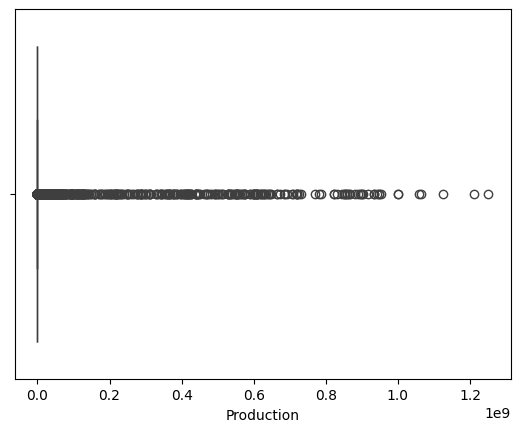

In [9]:
sns.boxplot(x=df['Production'])

In [10]:
(df['Production'] == 0.0).sum()

np.int64(0)

In [11]:
df['Production'].describe()

count    2.288060e+05
mean     6.148016e+05
std      1.756293e+07
min      1.000000e-02
25%      1.000000e+02
50%      8.300000e+02
75%      7.903750e+03
max      1.250800e+09
Name: Production, dtype: float64